In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical

### Считывание исходных данных.

In [6]:
data = pd.read_csv("data.csv")
data.iloc[1]

label         6
pixel1      155
pixel2      157
pixel3      156
pixel4      156
           ... 
pixel780    163
pixel781    175
pixel782    103
pixel783    135
pixel784    149
Name: 1, Length: 785, dtype: int64

## Формулировка задания:
### Анализ данных Sign Language MNIST

Оригинальный датасет MNIST, содержащий изображения рукописных цифр, является популярным эталоном для методов машинного обучения, работающих с изображениями. Однако в последнее время исследователи активно обновляют его и разрабатывают заменители, которые ставят более сложные задачи для компьютерного зрения и имеют большую прикладную ценность для реального мира. Например, в альтернативе под названием Fashion-MNIST исследователи из Zalando отметили удивительный факт: *"Большинство пар цифр из MNIST (784 пикселя на каждую выборку) можно довольно хорошо отличить друг от друга, используя всего один пиксель"*. Чтобы стимулировать разработку подобных замен, был создан датасет **Sign Language MNIST**, который повторяет формат CSV оригинального MNIST, включающий метки классов и значения пикселей в строках.

---

## Описание датасета

- **Многоклассовая задача:** Датасет представляет собой многоклассовую задачу с 24 классами, где каждый класс соответствует буквам американского алфавита (за исключением `J` и `Z`, которые требуют движения жестов).
- **Формат:** Каждое тренировочное и тестовое наблюдение содержит:
  - Метку класса (`0-25`) для букв от `A` до `Z` (без `J` и `Z`).
  - Значения пикселей в формате `label, pixel1, pixel2, …, pixel784`.
- **Размер изображений:** Каждое изображение — это 28x28 пикселей в градациях серого (значения от 0 до 255).
- **Количество данных:**
  - 27,455 образцов в тренировочной выборке.
  - 7,172 образца в тестовой выборке.
  Это примерно половина объема данных оригинального MNIST.

---

## Подготовка данных

Исходные изображения жестов рук были получены от нескольких пользователей, воспроизводивших жесты на разных фонах. Чтобы создать более объемный и полезный набор данных, был разработан процесс генерации дополнительных изображений:

1. **Предобработка:**
   - Кадрирование (обрезка области руки).
   - Перевод в градации серого.
   - Изменение размера до 28x28 пикселей.

2. **Аугментация данных:**
   - Применение различных фильтров (`Mitchell`, `Robidoux`, `Catrom`, `Spline`, `Hermite`).
   - Случайная пикселизация (5%).
   - Изменение яркости и контрастности (±15%).
   - Поворот изображения (на ±3 градуса).

Каждое оригинальное изображение было преобразовано в более чем 50 вариаций, что позволило увеличить объем данных и улучшить качество разделения классов.

---


## Посмотрим на изображения)

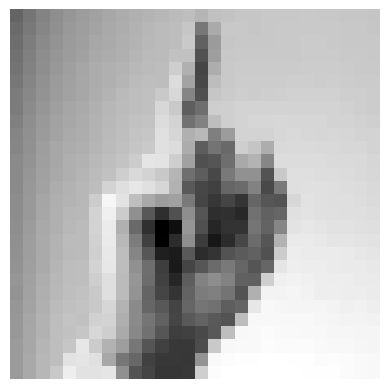

In [7]:
tmp = np.array((data.iloc[0].values[1:]))
plt.imshow(tmp.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()


## Начало проведения обучения.
## 1. Разделение выборки на тестовую и тренировочную.

In [8]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
print(f"Кол-во сэмплов в тренировочной выборке: {train_data.shape[0]}")
print(f"Кол-во сэмплов в тестовой выборке: {test_data.shape[0]}")

Кол-во сэмплов в тренировочной выборке: 21964
Кол-во сэмплов в тестовой выборке: 5491


## Разделение данных на признаки и метки как для тестовой, так и для тренеровочной.

In [9]:
X_train = train_data.iloc[:, 1:].values  # Все пиксели
y_train = train_data.iloc[:, 0].values  # Метки (0-25)
X_test = test_data.iloc[:, 1:].values
y_test = test_data.iloc[:, 0].values

## 2. Предобработка данных
# Преобразование в 28x28 изображения

In [10]:
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0  # Нормализация в диапазон [0, 1]
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# One-hot encoding меток

In [11]:
y_train = to_categorical(y_train, num_classes=25)  # 25 классов (A-Y, исключая J и Z)
y_test = to_categorical(y_test, num_classes=25)

## 3. Создание модели CNN
# Описание модели

Данная модель представляет собой сверточную нейронную сеть (CNN), предназначенную для классификации изображений с 25 классами. Она состоит из двух сверточных блоков и плотных слоев.

# 1. Модель `Sequential`

Модель использует класс `Sequential` из Keras. Это означает, что слои добавляются поочередно, каждый слой принимает на вход данные от предыдущего.

---

# 2. Первый сверточный блок

- **Conv2D**: Слой свертки, который применяет фильтры для извлечения признаков из изображений.
  - `filters=16`: Указывает количество фильтров (16), которые будут применяться.
  - `kernel_size=(3, 3)`: Размер каждого фильтра — 3x3.
  - `activation='relu'`: Функция активации ReLU, которая добавляет нелинейность в модель.
  - `input_shape=(28, 28, 1)`: Размер входных данных — изображения размером 28x28 пикселей с 1 каналом (черно-белое изображение).

- **MaxPooling2D**: Выполняет операцию пулинга для уменьшения размерности данных.
  - `pool_size=(2, 2)`: Размер окна пулинга — 2x2, что уменьшает размерность в два раза.

- **Dropout**: Регуляризирует модель, отключая определенный процент нейронов на каждом шаге, чтобы предотвратить переобучение.
  - `rate=0.1`: 10% нейронов будут отключены.

---

# 3. Второй сверточный блок

- **Conv2D**: Второй сверточный слой с 32 фильтрами.
  - `filters=32`: Количество фильтров в этом слое.
  - `kernel_size=(3, 3)`: Размер фильтров — 3x3.
  - `activation='relu'`: Функция активации ReLU.

- **MaxPooling2D**: Пулинг для уменьшения размерности данных.
  - `pool_size=(2, 2)`: Размер окна пулинга.

- **Dropout**: 10% нейронов отключается для предотвращения переобучения.

---

# 4. Плотные слои

- **Flatten**: Преобразует многомерные данные, выходящие из сверточных слоев, в одномерный вектор, чтобы передать его в плотные слои.

- **Dense**: Плотный слой с 64 нейронами и функцией активации ReLU.
  - `units=64`: Количество нейронов в этом слое.
  - `activation='relu'`: Функция активации ReLU.

- **Dropout**: Регуляризация для предотвращения переобучения, отключая 30% нейронов.
  - `rate=0.3`: 30% нейронов будет отключено.

- **Dense**: Выходной слой с 25 нейронами для многоклассовой классификации.
  - `units=25`: Количество классов для классификации.
  - `activation='softmax'`: Функция активации softmax для многоклассовой классификации.

---

# Описание параметров:

1. **Conv2D**: Слой свертки, который извлекает признаки из изображений.
   - `filters`: Количество фильтров, применяемых к входным данным.
   - `kernel_size`: Размер фильтров.
   - `activation`: Функция активации, используемая после свертки.

2. **MaxPooling2D**: Выполняет пулинг для уменьшения размерности данных.
   - `pool_size`: Размер окна пулинга.

3. **Dropout**: Регуляризирует модель, отключая определенный процент нейронов.
   - `rate`: Процент нейронов, который будет отключен.

4. **Flatten**: Преобразует многомерные данные в одномерный вектор для передачи в плотные слои.

5. **Dense**: Плотные слои для классификации.
   - `units`: Количество нейронов в слое.
   - `activation`: Функция активации для слоя.

6. **Softmax**: Функция активации, которая используется на выходном слое для многоклассовой классификации.

---

# P.S.

  В коде представлен пример для упрошенной модели, которая показывает результаты хуже.

---

In [12]:
model = Sequential([
    Input(shape=(28, 28, 1)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(25, activation='softmax')  # 25 классов
])

# Упрощённая модель
# model = Sequential([
#     # Один сверточный блок
#     Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
#     MaxPooling2D((2, 2)),
#     Dropout(0.1),  # Умеренная регуляризация
#
#     # Плотные слои
#     Flatten(),
#     Dense(32, activation='relu'),  # Меньше нейронов
#     Dropout(0.2),  # Умеренный Dropout
#     Dense(25, activation='softmax')  # Выходной слой с 25 классами
# ])

# Компиляция модели
После того как модель определена, она компилируется с использованием следующих параметров:
- **optimizer**: `adam` — эффективный оптимизатор, часто используемый для обучения нейронных сетей.
- **loss**: `categorical_crossentropy` — функция потерь для многоклассовой классификации.
- **metrics**: `accuracy` — метрика точности, которая отслеживает процент правильных классификаций.

In [13]:
# precision = Precision()
# recall = Recall()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', "precision", "recall"])

## 4. Обучение модели

In [14]:
history = model.fit(
    X_train, y_train,
    epochs=14,
    batch_size=64,
    validation_split=0.2,  # 20% данных для проверки вывода метрик
    verbose=1,
)

Epoch 1/14
275/275 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.0941 - loss: 3.0430 - precision: 0.3998 - recall: 0.0049 - val_accuracy: 0.6260 - val_loss: 1.5992 - val_precision: 0.9572 - val_recall: 0.1222
Epoch 2/14
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4361 - loss: 1.7564 - precision: 0.7455 - recall: 0.1810 - val_accuracy: 0.7960 - val_loss: 0.7919 - val_precision: 0.9527 - val_recall: 0.5322
Epoch 3/14
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5941 - loss: 1.2028 - precision: 0.8067 - recall: 0.3930 - val_accuracy: 0.8921 - val_loss: 0.5036 - val_precision: 0.9727 - val_recall: 0.7214
Epoch 4/14
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6913 - loss: 0.9083 - precision: 0.8324 - recall: 0.5317 - val_accuracy: 0.9310 - val_loss: 0.3374 - val_precision: 0.9760 - val_recall: 0.8325
Epoch 5/14
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7444 - loss: 0.7269 - precision: 0.8554 - recall: 0.6265 - val_accuracy: 0.9577 - val_loss: 0.

## 5. Оценка модели

In [15]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=0)
# print(f"Точность на тестовой выборке: {test_accuracy:.2f}")

# Визуализация метрик

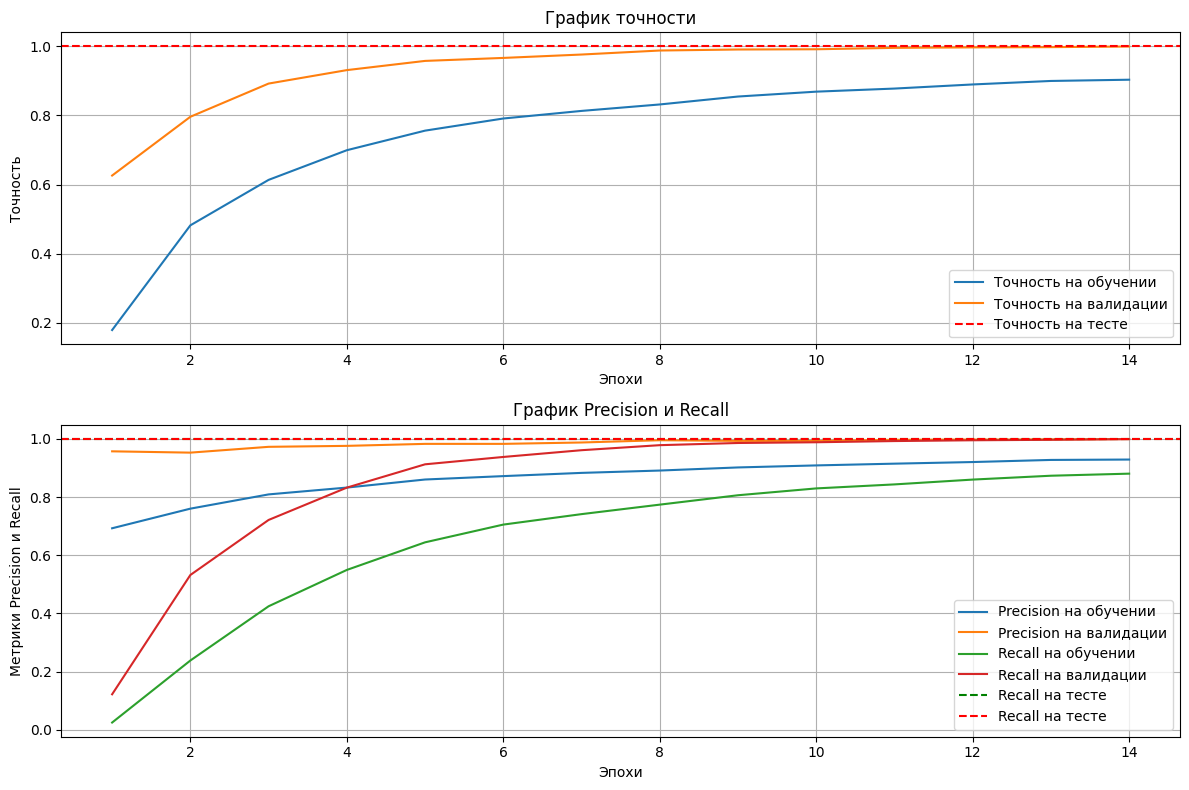

In [16]:
# Построение графиков обучения
plt.figure(figsize=(12, 8))
epochs = range(1, len(history.history['accuracy']) + 1)

plt.subplot(2, 1, 1)
plt.plot(epochs, history.history['accuracy'], label='Точность на обучении')
plt.plot(epochs, history.history['val_accuracy'], label='Точность на валидации')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Точность на тесте')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.grid()
plt.legend()
plt.title('График точности')

# Precision и Recall
plt.subplot(2, 1, 2)
plt.plot(epochs, history.history['precision'], label='Precision на обучении')
plt.plot(epochs, history.history['val_precision'], label='Precision на валидации')
plt.plot(epochs, history.history['recall'], label='Recall на обучении')
plt.plot(epochs, history.history['val_recall'], label='Recall на валидации')
plt.axhline(y=test_recall, color='g', linestyle='--', label='Recall на тесте')
plt.axhline(y=test_precision, color='r', linestyle='--', label='Recall на тесте')
plt.xlabel('Эпохи')
plt.ylabel('Метрики Precision и Recall')
plt.legend()
plt.grid()
plt.title('График Precision и Recall')

plt.tight_layout()
plt.show()

### Анализ графиков

Данные графики отображают динамику изменения метрик (точности, Precision и Recall) на различных этапах обучения модели: тренировочной, валидационной и тестовой выборках.

---

#### График точности

- **Точность на обучении** (синяя линия):
  Тренировочная точность демонстрирует стабильный рост по мере увеличения числа эпох, что указывает на корректное обучение модели. Модель постепенно становится способной более точно классифицировать тренировочные данные.

- **Точность на валидации** (оранжевая линия):
  Валидационная точность также увеличивается, причём она оказывается выше, чем на тренировке. Это может быть связано с тем, что выставлен dropout в самой модели, что сказывается на определении метрики на тестовой выборке.

- **Точность на тесте** (красная пунктирная линия):
  Итоговая точность на тестовых данных остаётся близкой к точности на валидации, что свидетельствует о хорошей обобщающей способности модели и отсутствии переобучения.

---

#### График Precision и Recall

- **Precision на обучении** (синяя линия):
  Precision на тренировочных данных растёт, что показывает улучшение способности модели уменьшать количество ложных срабатываний на тренировочных примерах.

- **Precision на валидации** (красная линия):
  Precision на валидационной выборке постепенно увеличивается. Его значение выше, чем на тренировочных данных, что может свидетельствовать о более сбалансированных данных в валидации.

- **Recall на обучении** (зелёная линия):
  Recall модели на тренировочных данных стабильно растёт, показывая, что модель всё лучше охватывает положительные примеры.

- **Recall на валидации** (голубая линия):
  Recall на валидации постепенно увеличивается. Несмотря на некоторое отставание от тренировочного Recall на начальных этапах, в финальных эпохах показатели становятся близкими.

- **Recall на тесте** (зелёная пунктирная линия):
  Recall на тестовых данных практически совпадает с валидационным, что является признаком хорошей обобщающей способности.

---

### Выводы

1. **Тестовые данные**:
   - Метрики на тестовых данных (точность, Precision и Recall) близки к значениям на валидации. Это свидетельствует о том, что модель хорошо обобщает, и отсутствуют признаки сильного переобучения или недообучения.

2. **Обобщающая способность**:
   - Результаты на тестовых данных указывают на то, что модель способна применять свои знания к ранее невидимым данным, что особенно важно для практического применения модели.



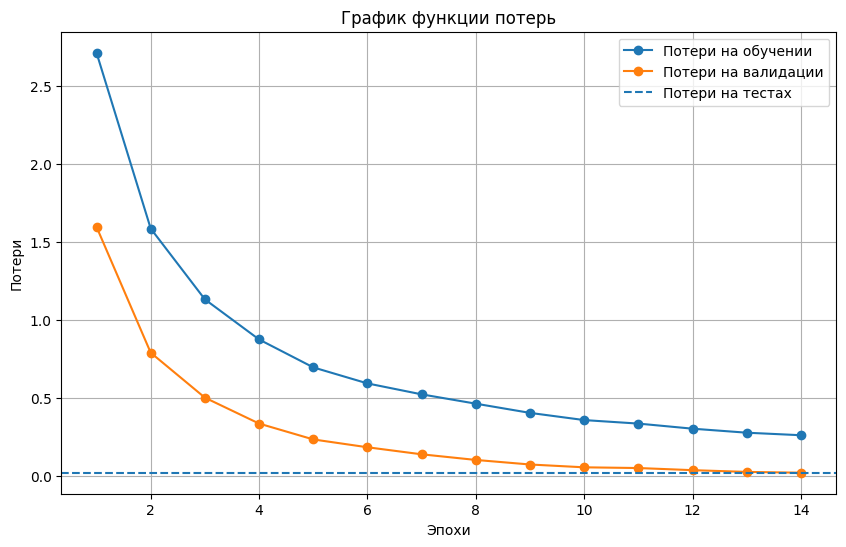

In [17]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Количество эпох
epochs = range(1, len(train_loss) + 1)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Потери на обучении', marker='o')
plt.plot(epochs, val_loss, label='Потери на валидации', marker='o')
plt.axhline(y=test_loss, label="Потери на тестах", linestyle="--")
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.title('График функции потерь')
plt.legend()
plt.grid()
plt.show()

### Анализ поведения функции ошибки

График функции ошибки отображает изменения значения ошибки модели в процессе обучения, включая результаты на тренировочной, валидационной и тестовой выборках.

---

#### Поведение функции ошибки

- **Ошибка на обучении**:
  Значение функции ошибки на тренировочной выборке уменьшается по мере увеличения числа эпох. Это свидетельствует о том, что модель успешно минимизирует функцию потерь на данных, используемых для обучения.

- **Ошибка на валидации**:
  Ошибка на валидационной выборке также снижается, но ее значения на протяжении всего обучения оказываются ниже, чем на тренировочной выборке. Это поведение допустимо, поскольку модель регуляризована (за счет Dropout), что снижает вероятность переобучения. Низкие значения ошибки на валидации подтверждают, что модель хорошо обобщает данные, не сталкиваясь с сильным переобучением.

- **Ошибка на тесте**:
  Ошибка на тестовой выборке в последней эпохе оказывается близкой к ошибке на валидации. Это говорит о том, что модель сохраняет свою обобщающую способность и на данных, которые она не видела в процессе обучения. Минимальное значение функции ошибки на тесте и валидации подтверждает, что модель хорошо справляется с задачей на новых данных.

---

#### Выводы

1. **Снижение ошибки**: Уменьшение значений функции ошибки на тренировочной и валидационной выборках показывает, что модель успешно учится и стабильно улучшает свои прогнозы.

2. **Соответствие ошибок на тесте и валидации**: Близость значений функции ошибки на валидации и тесте говорит о том, что модель обладает высокой обобщающей способностью и надежно работает на неизвестных данных.

3. **Низкие значения ошибки**: Итоговые низкие значения функции ошибки на всех выборках (особенно на тестовой) подтверждают, что модель достигает высокого качества при решении задачи, эффективно минимизируя потери.


# 7. Прогнозирование на тестовых данных

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


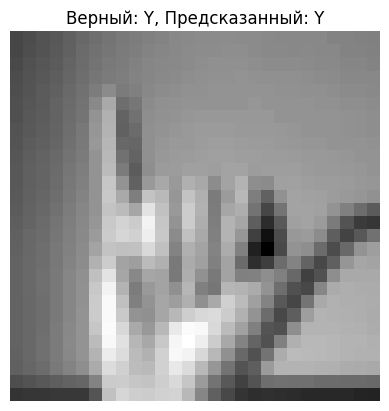

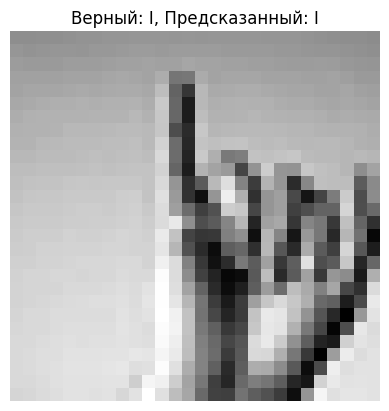

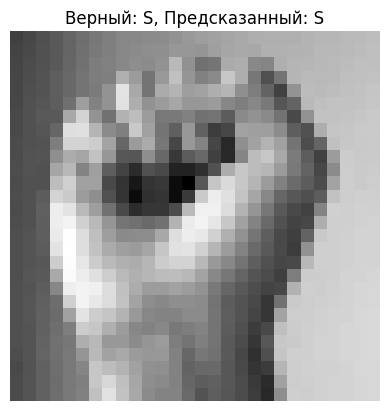

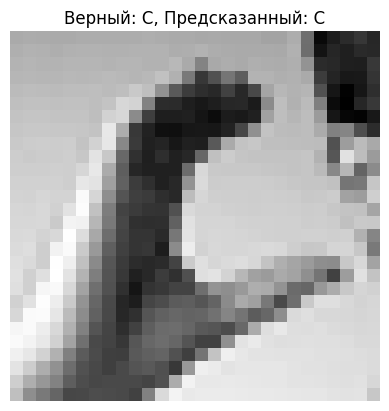

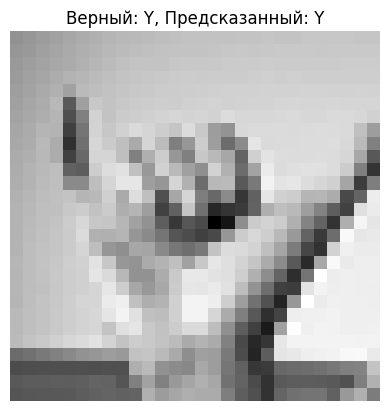

In [18]:
predictions = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Пример визуализации предсказания
for i in range(5):
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    plt.title(f"Верный: {chr(y_true[i] + 65)}, Предсказанный: {chr(predictions[i] + 65)}")
    plt.axis('off')
    plt.show()
